In [1]:
#hide
from utils import *
from fastai2.vision.widgets import *

## Gathering data

In [2]:
key = 'XXXX'

In [3]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [4]:
results = search_images_bing(key, 'iron man')
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
#hide
ims = ['https://cdn.telanganatoday.com/wp-content/uploads/2020/01/ROBERT-IRON-MAN.jpg']

In [6]:
dest = 'images/iron_man.jpg'
download_url(ims[0], dest)

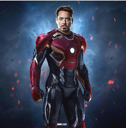

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
bear_types = 'iron_man','war_machine','iron_patriot'
path = Path('superheroes')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [10]:
fns = get_image_files(path)
fns

(#428) [Path('superheroes/iron_man/00000003.jpg'),Path('superheroes/iron_man/00000006.jpg'),Path('superheroes/iron_man/00000001.jpg'),Path('superheroes/iron_man/00000002.jpg'),Path('superheroes/iron_man/00000005.jpg'),Path('superheroes/iron_man/00000008.jpg'),Path('superheroes/iron_man/00000000.jpg'),Path('superheroes/iron_man/00000007.jpg'),Path('superheroes/iron_man/00000004.jpg'),Path('superheroes/iron_man/00000009.jpg')...]

In [11]:
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#7) [Path('superheroes/iron_man/00000143.jpg'),Path('superheroes/war_machine/00000046.jpg'),Path('superheroes/war_machine/00000089.png'),Path('superheroes/war_machine/00000100.jpg'),Path('superheroes/iron_patriot/00000022.jpg'),Path('superheroes/iron_patriot/00000078.jpg'),Path('superheroes/iron_patriot/00000131.jpg')]

In [12]:
failed.map(Path.unlink);

## From data to DataLoaders

In [13]:
superheroes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = superheroes.dataloaders(path)

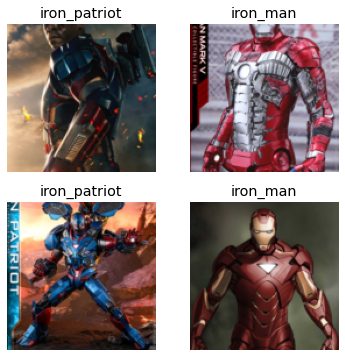

In [16]:
dls.valid.show_batch(max_n=4)

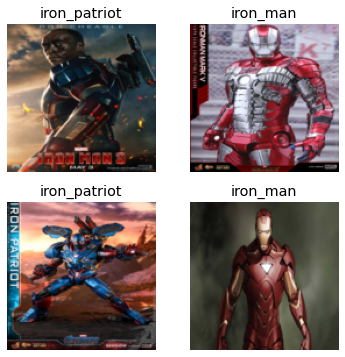

In [18]:
superheroes = superheroes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = superheroes.dataloaders(path)
dls.valid.show_batch(max_n=4)

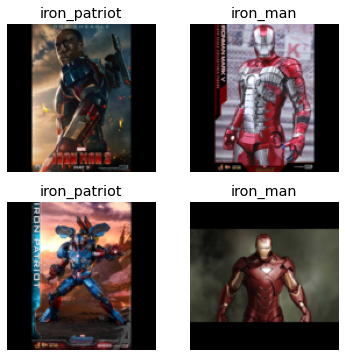

In [20]:
superheroes = superheroes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = superheroes.dataloaders(path)
dls.valid.show_batch(max_n=4)

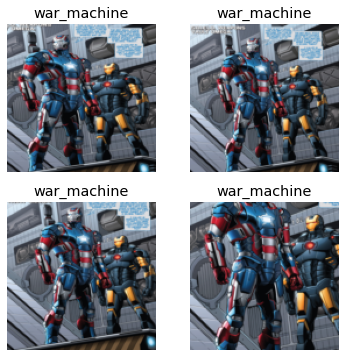

In [22]:
superheroes = superheroes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = superheroes.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=4)

### Data augmentation

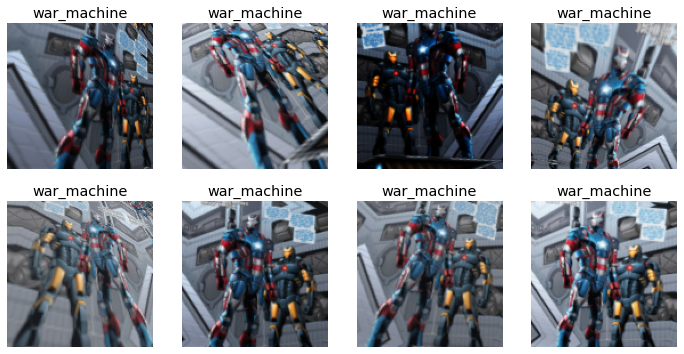

In [24]:
superheroes = superheroes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = superheroes.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8)

## Training your model, and using it to clean your data

In [25]:
superheroes = superheroes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = superheroes.dataloaders(path)

In [26]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.641343,1.097617,0.396825,00:10


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.834179,0.494179,0.190476,00:09
1,0.607170,0.317444,0.095238,00:10
2,0.502483,0.306737,0.087302,00:09
3,0.444090,0.310426,0.095238,00:09


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


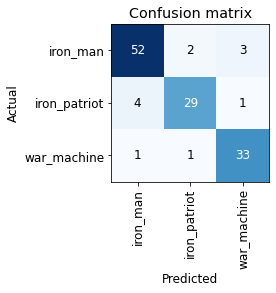

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

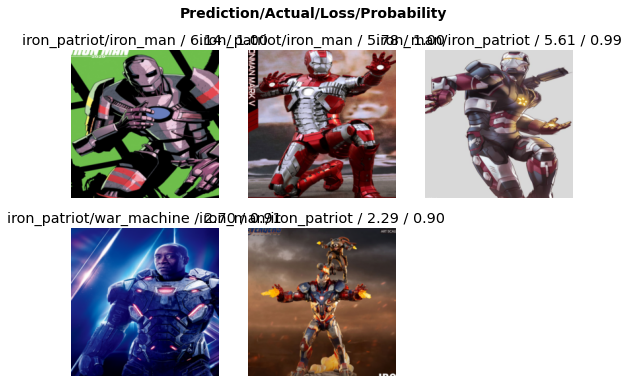

In [29]:
interp.plot_top_losses(5)

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [36]:
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

### Using the model for inference

In [37]:
learn.export()

In [38]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [39]:
learn_inf = load_learner(path/'model.pkl')

In [40]:
learn_inf.predict('images/iron_man.jpg')

('iron_man', tensor(0), tensor([0.5118, 0.4591, 0.0291]))

In [41]:
learn_inf.dls.vocab

(#3) ['iron_man','iron_patriot','war_machine']